In [5]:
# ============================================================
# CELL 1 — Imports and Paths
# ============================================================
!pip install tensorflow==2.15.0 scikit-learn matplotlib pandas --quiet

import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, classification_report
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from google.colab import drive

drive.mount('/content/drive')

DRIVE_DIR = "/content/drive/MyDrive/acne clean pigmentation wrinkles"
TRAIN_CSV = f"{DRIVE_DIR}/train_split_dedup.csv"
VAL_CSV   = f"{DRIVE_DIR}/val_split_dedup.csv"
MODEL_OUT = f"{DRIVE_DIR}/densenet_skin_multilabel.keras"
CLASSES   = ["acne","pigmentation","wrinkles"]

train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)
print(f"Train:{len(train_df)}, Val:{len(val_df)}")


ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.15.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train:3562, Val:955


In [6]:
# ============================================================
# CELL 2 — Data Generators (Multi-Label)
# ============================================================
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col=CLASSES,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw"
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col=CLASSES,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    shuffle=False
)


Found 3562 validated image filenames.
Found 955 validated image filenames.


In [7]:
# ============================================================
# CELL 3 — Build DenseNet121 Model
# ============================================================
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(len(CLASSES), activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# freeze backbone initially
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_4    │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_4… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_5    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_5… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,040,579 (26.86 MB)

 Trainable params: 3,075 (12.01 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [8]:
# ============================================================
# CELL 4 — Callbacks and Training
# ============================================================
ckpt = ModelCheckpoint(MODEL_OUT, monitor="val_loss", save_best_only=True, verbose=1)
early = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
lrred = ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, verbose=1)

EPOCHS = 20
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[ckpt, early, lrred]
)

# --- Fine-tune last 50 layers ---
for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(optimizer=Adam(1e-5),
              loss="binary_crossentropy",
              metrics=["accuracy"])

history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[ckpt, early, lrred]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.1922 - loss: 0.7517
Epoch 1: val_loss improved from inf to 0.46742, saving model to /content/drive/MyDrive/acne clean pigmentation wrinkles/densenet_skin_multilabel.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 1340s 12s/step - accuracy: 0.1928 - loss: 0.7508 - val_accuracy: 0.3665 - val_loss: 0.4674 - learning_rate: 1.0000e-04
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.4775 - loss: 0.4947
Epoch 2: val_loss improved from 0.46742 to 0.38467, saving model to /content/drive/MyDrive/acne clean pigmentation wrinkles/densenet_skin_multilabel.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 1460s 13s/step - accuracy: 0.4777 - loss: 0.4946 - val_accuracy: 0.4565 - val_loss: 0.3847 - learning_rate: 1.0000e-04
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5314 - loss: 0.4330
Epoch 3: val_loss improved from 0.38467 to 0.33036, saving model to /content/drive/MyDrive/acne clean pigmentation wrinkles/densenet_skin_mul

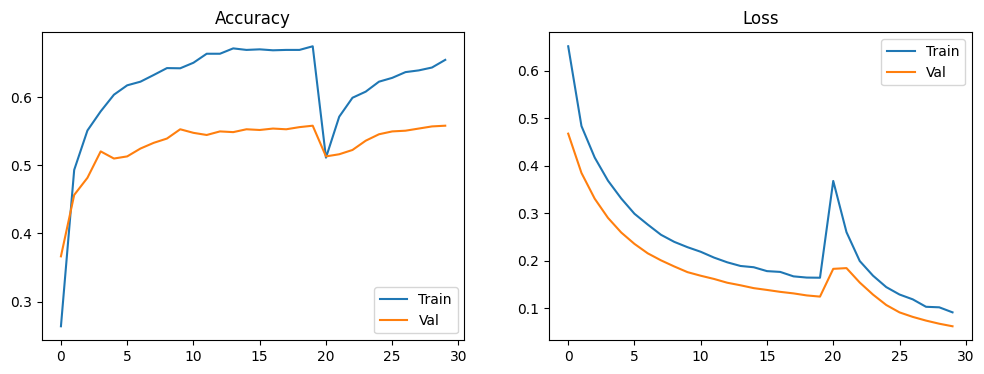

30/30 ━━━━━━━━━━━━━━━━━━━━ 170s 6s/step
ROC-AUC (macro): 0.9949

Classification Report (thr=0.5)
              precision    recall  f1-score   support

        acne       0.98      0.98      0.98       259
pigmentation       0.93      0.87      0.90        94
    wrinkles       0.91      0.95      0.93       191

   micro avg       0.95      0.95      0.95       544
   macro avg       0.94      0.93      0.94       544
weighted avg       0.95      0.95      0.95       544
 samples avg       0.54      0.54      0.54       544



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
# ============================================================
# CELL 5 — Evaluation
# ============================================================
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'] + history_ft.history['accuracy'], label="Train")
plt.plot(history.history['val_accuracy'] + history_ft.history['val_accuracy'], label="Val")
plt.title("Accuracy"); plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'] + history_ft.history['loss'], label="Train")
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label="Val")
plt.title("Loss"); plt.legend()
plt.show()

val_gen.reset()
preds = model.predict(val_gen)
y_true = val_df[CLASSES].values

roc_auc = roc_auc_score(y_true, preds, average="macro")
print(f"ROC-AUC (macro): {roc_auc:.4f}")
print("\nClassification Report (thr=0.5)")
print(classification_report(y_true, (preds>0.5).astype(int), target_names=CLASSES))


30/30 ━━━━━━━━━━━━━━━━━━━━ 162s 5s/step


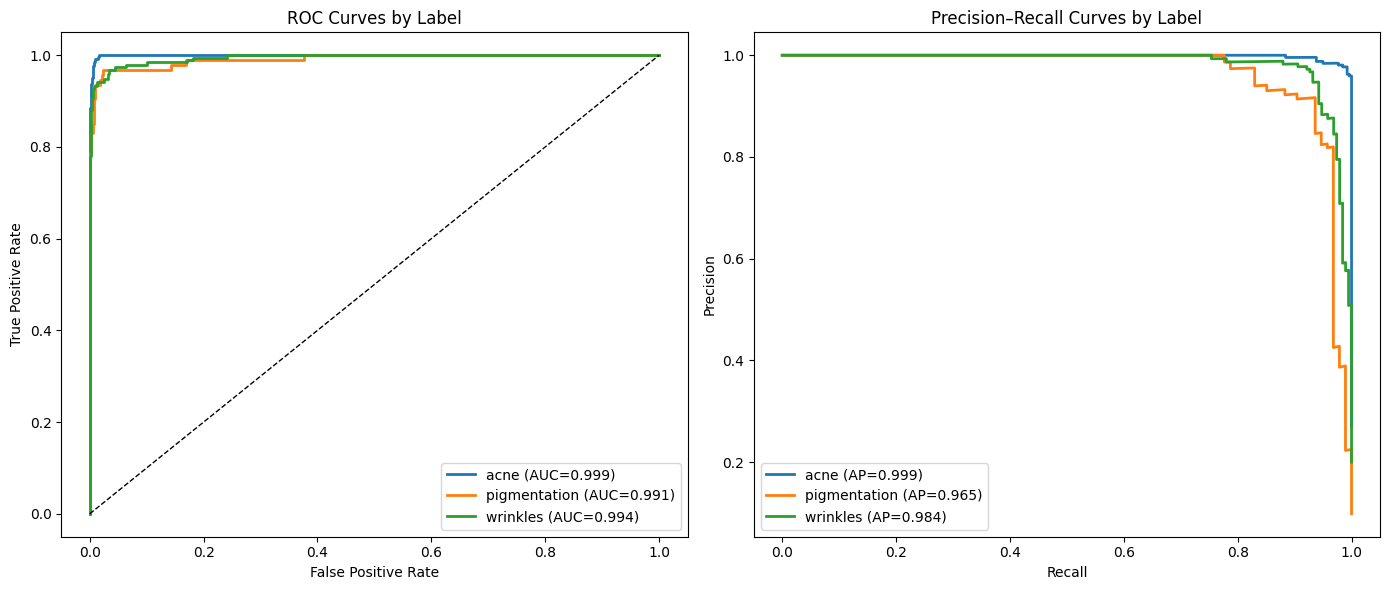

In [12]:
# ============================================================
# CELL 6 — Per-Label ROC + Precision-Recall Curves (Fixed)
# ============================================================
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# Ensure we have predictions
val_gen.reset()
preds = model.predict(val_gen, verbose=1)

y_true = val_df[CLASSES].values
y_pred = preds

plt.figure(figsize=(14,6))

# ----- ROC Curves -----
plt.subplot(1,2,1)
for i, c in enumerate(CLASSES):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{c} (AUC={roc_auc:.3f})")
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Label')
plt.legend(loc="lower right")

# ----- Precision–Recall Curves -----
plt.subplot(1,2,2)
for i, c in enumerate(CLASSES):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    ap = average_precision_score(y_true[:, i], y_pred[:, i])
    plt.plot(recall, precision, lw=2, label=f"{c} (AP={ap:.3f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curves by Label')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()


In [13]:
# ============================================================
# CELL 8 — Save Trained DenseNet Model
# ============================================================
model.save(MODEL_OUT)
print(f"✅ Model saved successfully at: {MODEL_OUT}")


✅ Model saved successfully at: /content/drive/MyDrive/acne clean pigmentation wrinkles/densenet_skin_multilabel.keras
